In [1]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
# import timeit
from scipy.integrate import odeint
from scipy import stats
from sklearn.manifold import MDS
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm
import modelSystems as ms
from EDMtoolkit import *
from modelSystems import *
import timeit

plt.rcParams['text.usetex'] = True

# %matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
A = np.linspace(0,5,num=10)
B = np.linspace(0,5,num=10)

B[3] += 0.1

np.sum(np.maximum(B - A, np.zeros(10)))

0.10000000000000009

In [3]:
nyears = 1

settlingTime = 2 ** 0
tlen = 2 ** 8
end = 2 ** 6 # 2**5 # (3.498901098901099 / (12*reduction)) * tlen # 2**3
reduction = 2 ** 0
# trainToTest = 0.80 # between 0 and 1

tr = np.linspace(0, end, num=tlen)
t = tr / end

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
ndrivers = 1

# t0 = np.array([0.34])
# t0 = np.ones(3) * 3# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
# 
# t0 = np.ones(5)
# t0[0] += 0.1
# t0 = np.array([0,5,15])

In [41]:
""" INITIAL CONDITIONS """
# x0 = np.array([3,250])
x0 = rand.random(5)
# x0 = np.array([0.1,0.4,9])
# x0 = rand.random(99)
# x0 = rand.random(3)

# m = 50
# x0 = np.ones(m) * (np.pi ** -1)
# x0[0] += 0.2
# x0[1] += 0.3
# x0 = np.array([1,5,9],dtype=float)

""" DRIVERS """
# Gmax = lambda t: 0.7 # +0.5*t/tlen
# r = lambda t: 4 # - t / tlen# - t # + 0.5 * np.sin(np.pi * t / tlen)
# m = lambda t: 0.3
# b1 = lambda t: 5 - 1.5 * np.cos(2*np.pi*t / end)
# b1 = lambda t: 2.5 + 4 * t / end
# c = lambda t: 2+2*t/256+np.sin(t)
# rho = lambda t : 28 # + 10 * t / end
# sigma = lambda t : 10 # + 10 * t / end
# beta = lambda t : 8.0 / 3.0 + 4*t/end
# m = lambda t : t / end
F = lambda t : 5 + 5 * t / end
N = 5 

""" GENERATE TS """
# Xr = ms.generateTimeSeriesContinuous('Lorenz', np.array([1,5,17]))
# Xr = generateTimeSeriesContinuous('RosslerP', np.array([1,1,1]), nsargs=(c,), end=256, tlen = 1024, reduction = 4)
# Xr = generateTimeSeriesContinuous("HastingsPowell", x0, tlen=tlen, end=end, reduction=reduction, settlingTime=settlingTime)
# Xr = standardize(generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime))[:,0,None]
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturation, x0, settlingTime=30, tlen=tlen)
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturationP, x0, settlingTime=30, tlen=tlen, nsargs=(Gmax,))
# Xr = generateTimeSeriesDiscrete("Tents", x0, settlingTime=0, tlen=tlen)
# Xr = generateTimeSeriesDiscrete("Tent", x0, nsargs=(m,), settlingTime=0, tlen=tlen)
# Xr = Xc[:,1,None]
# Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime)
# Xr = generateTimeSeriesDiscrete("LogisticIslandsP", x0, nsargs=(r, m), tlen=tlen, settlingTime=settlingTime)[:,4,None
# Xr = generateTimeSeriesContinuous('LorenzP', np.array([1,5,17]), nsargs=(rho, sigma, beta), tlen=tlen, end=end, settlingTime=settlingTime, reduction= reduction)[:,0,None]
Xr = generateTimeSeriesContinuous("Lorenz96P", x0, nsargs=(F, N), tlen=tlen, end=end, settlingTime=settlingTime, reduction= reduction)[:,N-1,None]


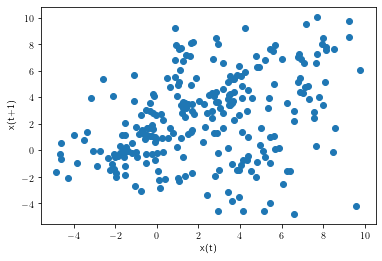

In [48]:
poincare2d(Xr)

In [42]:
# Add obversation noise to the data

a = 0.0
Xr += a * np.ptp(Xr) * rand.random(Xr.shape)

In [43]:
# FROM DATA

"""
file = "GPDD.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()

Xr = np.log(states[:,2,None]+1)
tr = states[:,3] - np.min(states[:,3])
tlen = states.shape[0]
"""

"""
num = "C"
file = f"../Datasets/Becks/Figure1Plot{num}.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
Xr = standardize(data[1:52].to_numpy()[:,1:4].astype(float))
t = np.linspace(0,1,num=Xr.shape[0])
tr = t
"""
# END FROM DATA

'\nnum = "C"\nfile = f"../Datasets/Becks/Figure1Plot{num}.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nXr = standardize(data[1:52].to_numpy()[:,1:4].astype(float))\nt = np.linspace(0,1,num=Xr.shape[0])\ntr = t\n'

In [44]:

""" UPDATE DRIVERS HERE """

digiDrivers = [F]

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
# gtsr = h2(t)
# gtsr = r(t) # driverArray
# gtsr = c(t)
# gtsr = beta(t)
# gtsr = m(t)
gtsr = F(t)

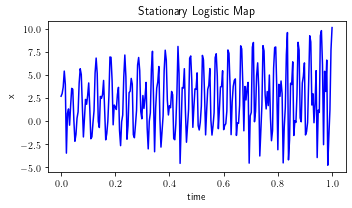

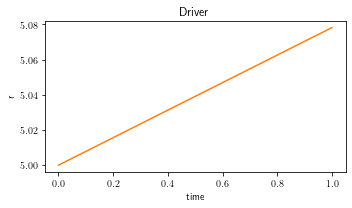

In [49]:
title = "Stationary Logistic Map"

fig2 = plt.figure(5, figsize=(5,3))

if dim == 1:
    ax2 = fig2.add_subplot(111)
    ax2.plot(t,Xr[:,0],"b") # states
    ax2.set_ylabel("x")
    ax2.set_xlabel("time")
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2], linewidth=1)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_xlabel("x(t)")
    ax2.set_ylabel("y(t)")
    ax2.set_zlabel("z(t)")
    
ax2.set_title(title)
    
plt.tight_layout()
""" 
ax2 = fig2.gca(projection="3d")
ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
# ax2.set_title("Rosenzweig MacArthur")
# plt.savefig("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(5,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(5,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(t,gtsr, c="tab:orange")
        axD.set_ylabel("r")
        axD.set_xlabel("time")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.tight_layout()
plt.show()

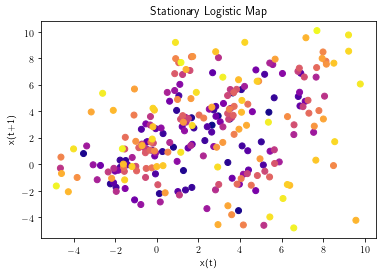

In [50]:
poincare2d(Xr, title=title, step=1, color_wrt_time=True)

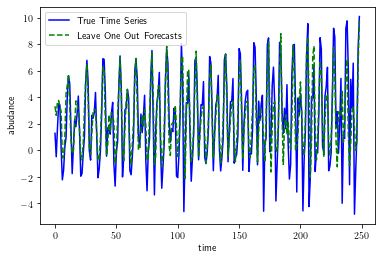

(3.4495346998106426, 0.6740938718048177, 57.42883644131916)

In [47]:
get_delta_agg(Xr, 6, return_forecast_skill=True)

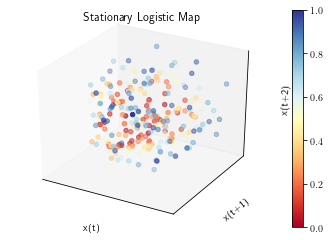

In [40]:
poincare3d(Xr, title=title, step=1, color_wrt_time=True)

In [50]:
horizon = 1
maxLags = 5

In [625]:
# thetaNS, deltaNS, llikelihoodNS, lagsNS, tauNS, thetaS, llikelihoodS, lagsS, tauS = optimizationSuite(Xr, tr, predictionHorizon, lagRange, tauRange, errFunc=logUnLikelihood)
thetaNS, deltaNS, errNS, lagsNS, tauNS, thetaS, errS, lagsS, tauS = optimizationSuite(Xr, t, horizon, maxLags, errFunc=logUnLikelihood)

E = 2, tau = 1


TypeError: optimizeG() got an unexpected keyword argument 'errFunc'

In [51]:
""" COMPUTE DOFS """

Xn, Yn, txn = delayEmbed(Xr, horizon, lagsNS, tauNS, t=t)
dofNS = dofestimation(Xn, Yn, txn, thetaNS, deltaNS)

Xs, Ys, txs = delayEmbed(Xr, horizon, lagsS, tauS, t=t)
dofS = dofestimation(Xs, Ys, txs, thetaS, 0)

NameError: name 'lagsNS' is not defined

In [541]:
predictedTSNS = leaveOneOut(Xn, Yn, txn, thetaNS, deltaNS)
predictedTSS = leaveOneOut(Xs, Ys, txs, thetaS, 0)

In [542]:
MSElooNS = np.sum((predictedTSNS - Yn) ** 2 )
MSElooS = np.sum((predictedTSS - Ys) ** 2 )

In [543]:
MSElooNS

0.005499335687314312

In [544]:
MSElooS

0.0057447427976500005

<IPython.core.display.Javascript object>


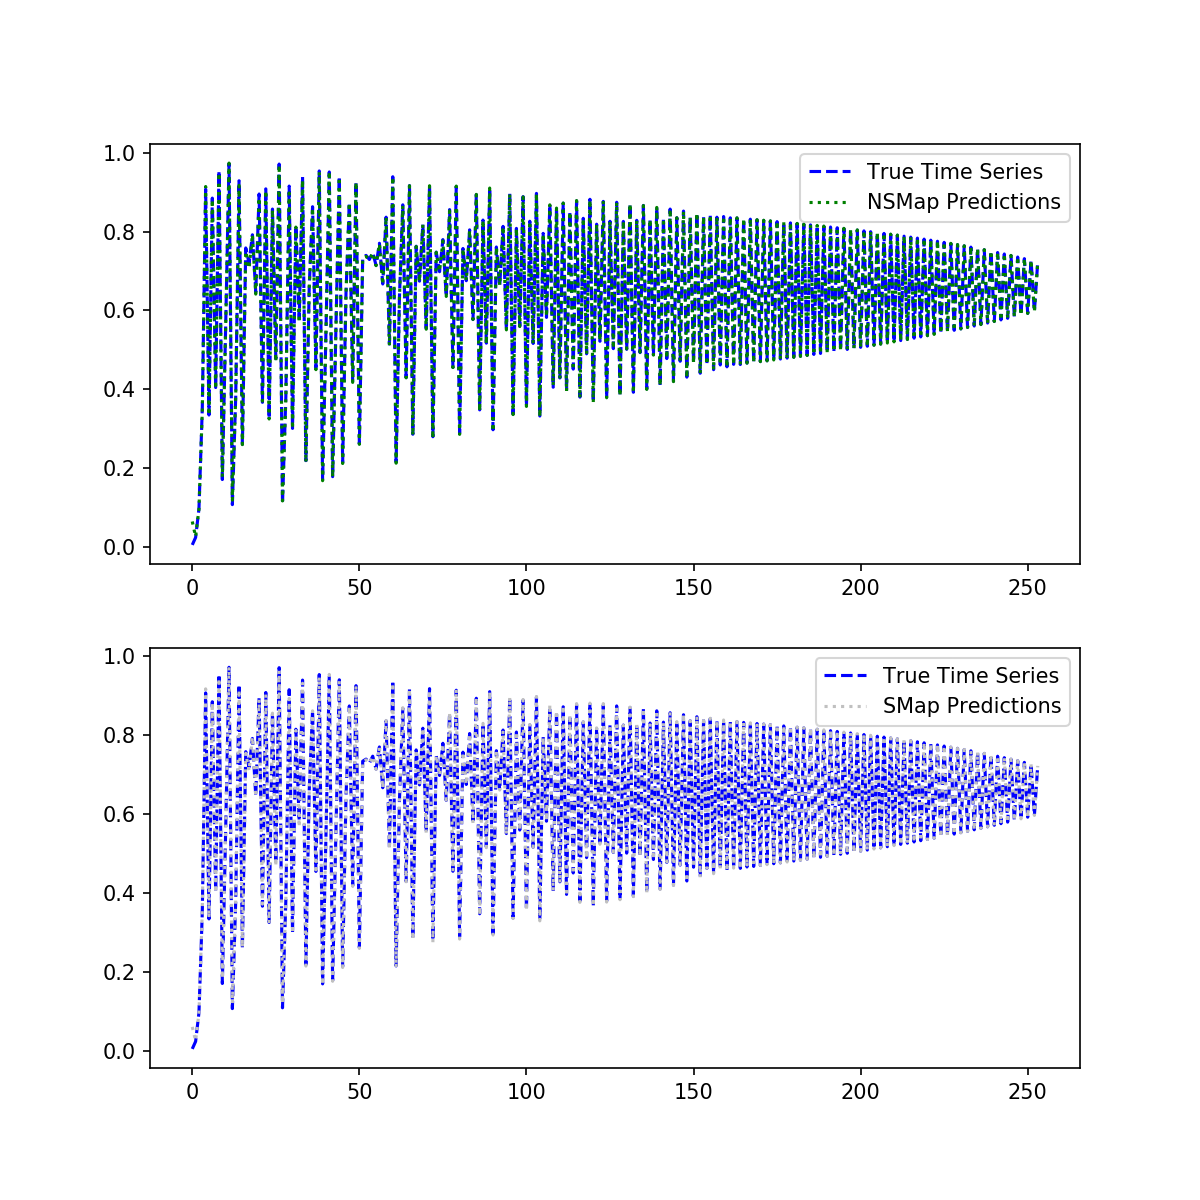

In [593]:
figLOU, axLOU = plt.subplots(2, figsize=(8,8))
axLOU[0].plot(Yn, c="blue", linestyle="dashed", label="True Time Series")
axLOU[0].plot(predictedTSNS, c="green", linestyle="dotted", label="NSMap Predictions")
axLOU[0].legend()

axLOU[1].plot(Ys, c="blue", linestyle="dashed", label="True Time Series")
axLOU[1].plot(predictedTSS, c="silver", linestyle="dotted", label="SMap Predictions")
axLOU[1].legend()
plt.show()

In [547]:
AICNS = AIC(Xn, Yn, txn, thetaNS, deltaNS)
AICS = AIC(Xs, Ys, txs, thetaS, 0)

In [548]:
sequentialNS = sequential(Xn, Yn, txn, thetaNS, deltaNS,return_error=False)
sequentialS = sequential(Xs, Ys, txs, thetaS, 0,return_error=False)

YseqNS = Yn[int(Yn.shape[0]/2):]
YseqS = Ys[int(Ys.shape[0]/2):]

In [549]:
MSEseqNS = np.mean((sequentialNS-YseqNS)**2)
MSEseqS = np.mean((sequentialS-YseqS)**2)

<IPython.core.display.Javascript object>


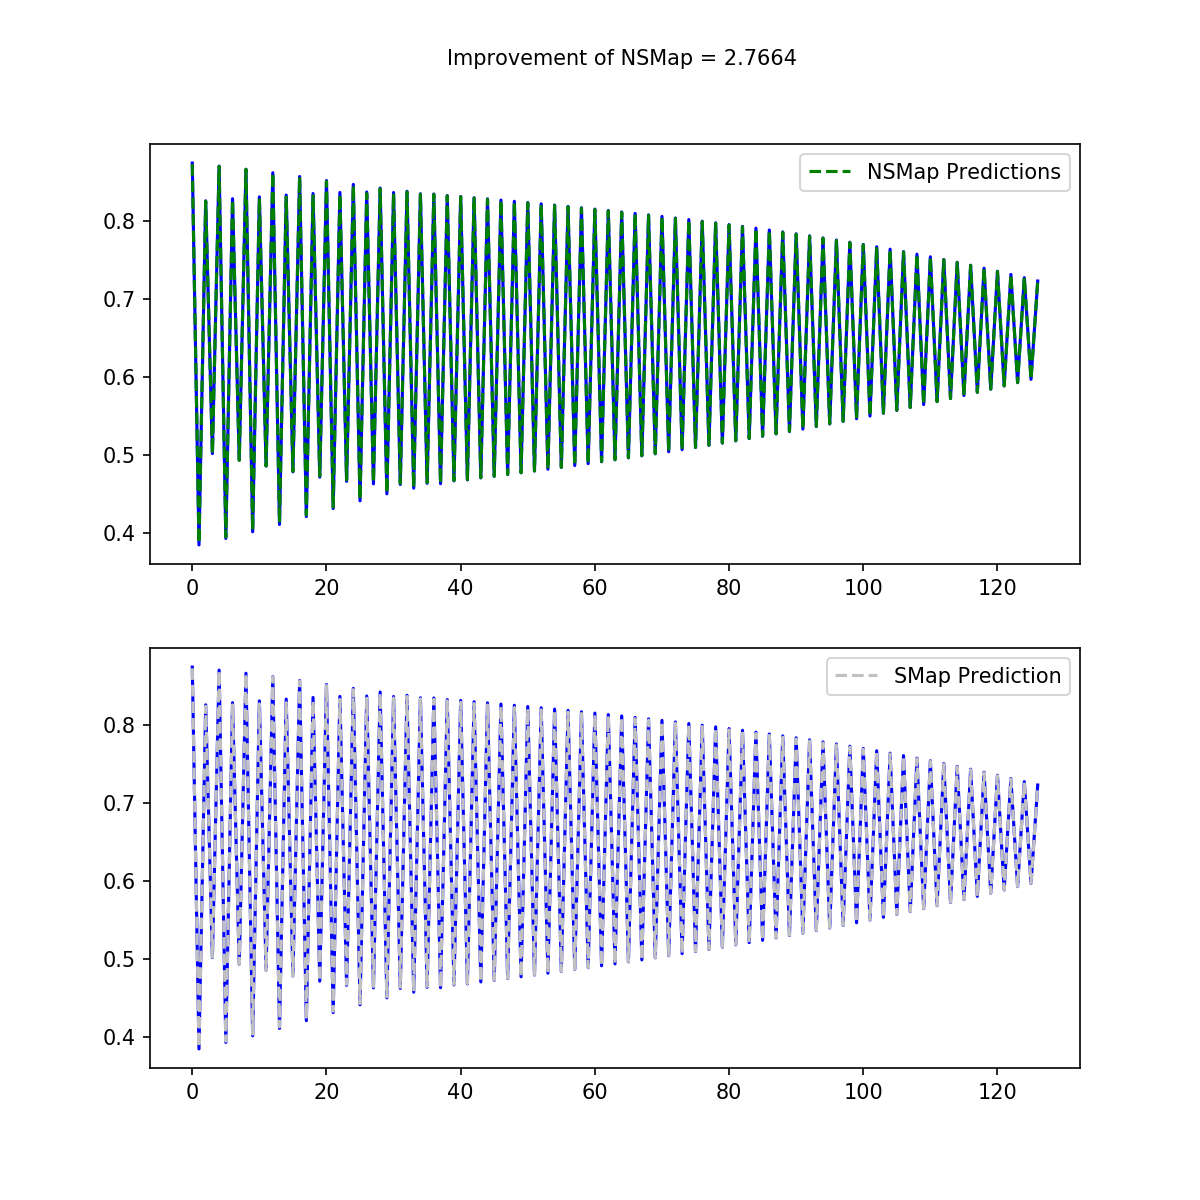

In [550]:
fig, ax = plt.subplots(2, figsize=(8,8))
ax[0].plot(Yn[int(Yn.shape[0]/2):], color="blue")
ax[0].plot(sequentialNS, color="green", linestyle="dashed", label="NSMap Predictions")
ax[0].text(38,1,f"Improvement of NSMap = {MSEseqS/MSEseqNS:.4f}")
ax[0].legend()

ax[1].plot(Ys[int(Ys.shape[0]/2):], color="blue")
ax[1].plot(sequentialS, color="silver", linestyle="dashed", label="SMap Prediction")
ax[1].legend()

plt.show()

In [157]:
# functionSurfaceNSMap(Xr, predictionHorizon, thetaBestNS, deltaBestNS, 15)

In [551]:
### SUMMARY ###

print(f"NSMap -- theta: {thetaNS:.3f}, delta: {deltaNS:.7f}, AIC: {AICNS:.3f}, log Likelihood: {errNS:.3f}, Optimal Embedding Dimension: {lagsNS+2}, 10% Weight Dropoff: {np.exp(-deltaNS*0.1**2)}")
print(f"SMap -- theta: {thetaS:.3f}, AIC: {AICS:.3f}, log Likelihood: {errS:.3f}, Optimal Embedding Dimension: {lagsS+2}")

print(f"Improvement of NSMap(leave one out): {MSElooS/MSElooNS:.3f}")
print(f"Improvement of NSMap(sequentially calculated): {MSEseqS/MSEseqNS:.3f}")

print(f"NSMap dof: {dofNS:.3f}")
print(f"SMap dof: {dofS:.3f}")

AkaikeTest(AICS, AICNS)

NSMap -- theta: 11.902, delta: 10.7955604, AIC: -1669.356, log Likelihood: -1043.307, Optimal Embedding Dimension: 3, 10% Weight Dropoff: 0.8976674485760936
SMap -- theta: 16.380, AIC: -1606.961, log Likelihood: -999.955, Optimal Embedding Dimension: 3
Improvement of NSMap(leave one out): 1.045
Improvement of NSMap(sequentially calculated): 2.766
NSMap dof: 102.948
SMap dof: 116.584
Probability SMap beats NSMap:  2.8256590616388657e-14


NSMap
SMap
DLM
NSMap
SMap
DLM
NSMap
SMap
DLM
NSMap
SMap
DLM
NSMap
SMap
DLM


<IPython.core.display.Javascript object>


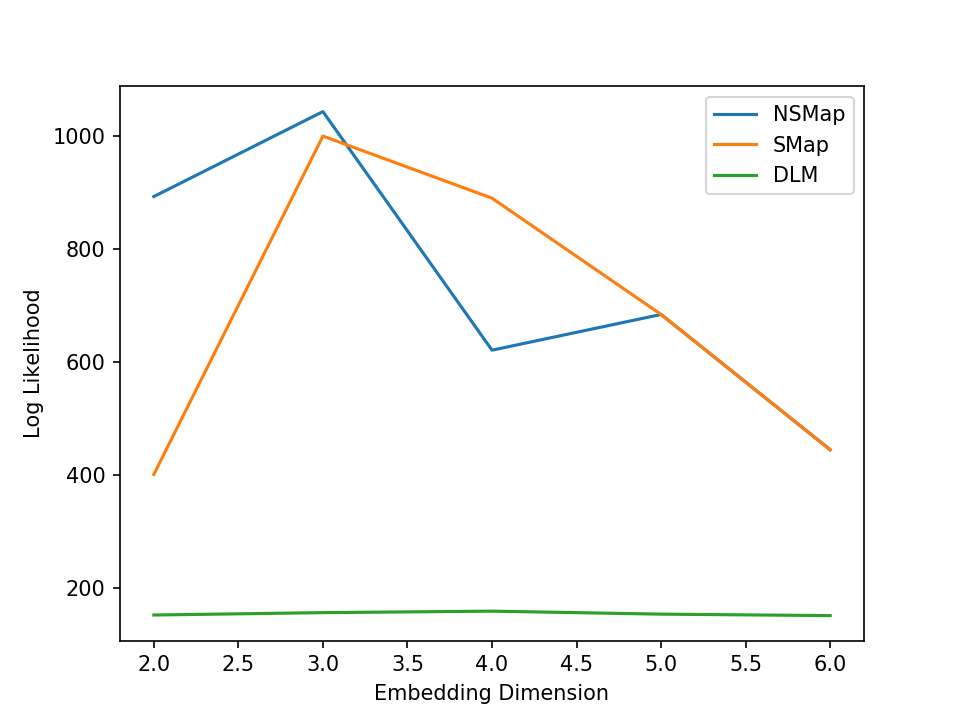

In [615]:
evslikelihood = EvsLikelihood(Xr, t, horizon, maxLags, errFunc=logUnLikelihood)

In [559]:
aggregated_delta = np.dot(deltaNSandDLM[:,0], evslikelihood[:,0] - evslikelihood[:,1]) / np.sum(evslikelihood[:,0] - evslikelihood[:,1])

ValueError: shapes (6,) and (5,) not aligned: 6 (dim 0) != 5 (dim 0)

<IPython.core.display.Javascript object>


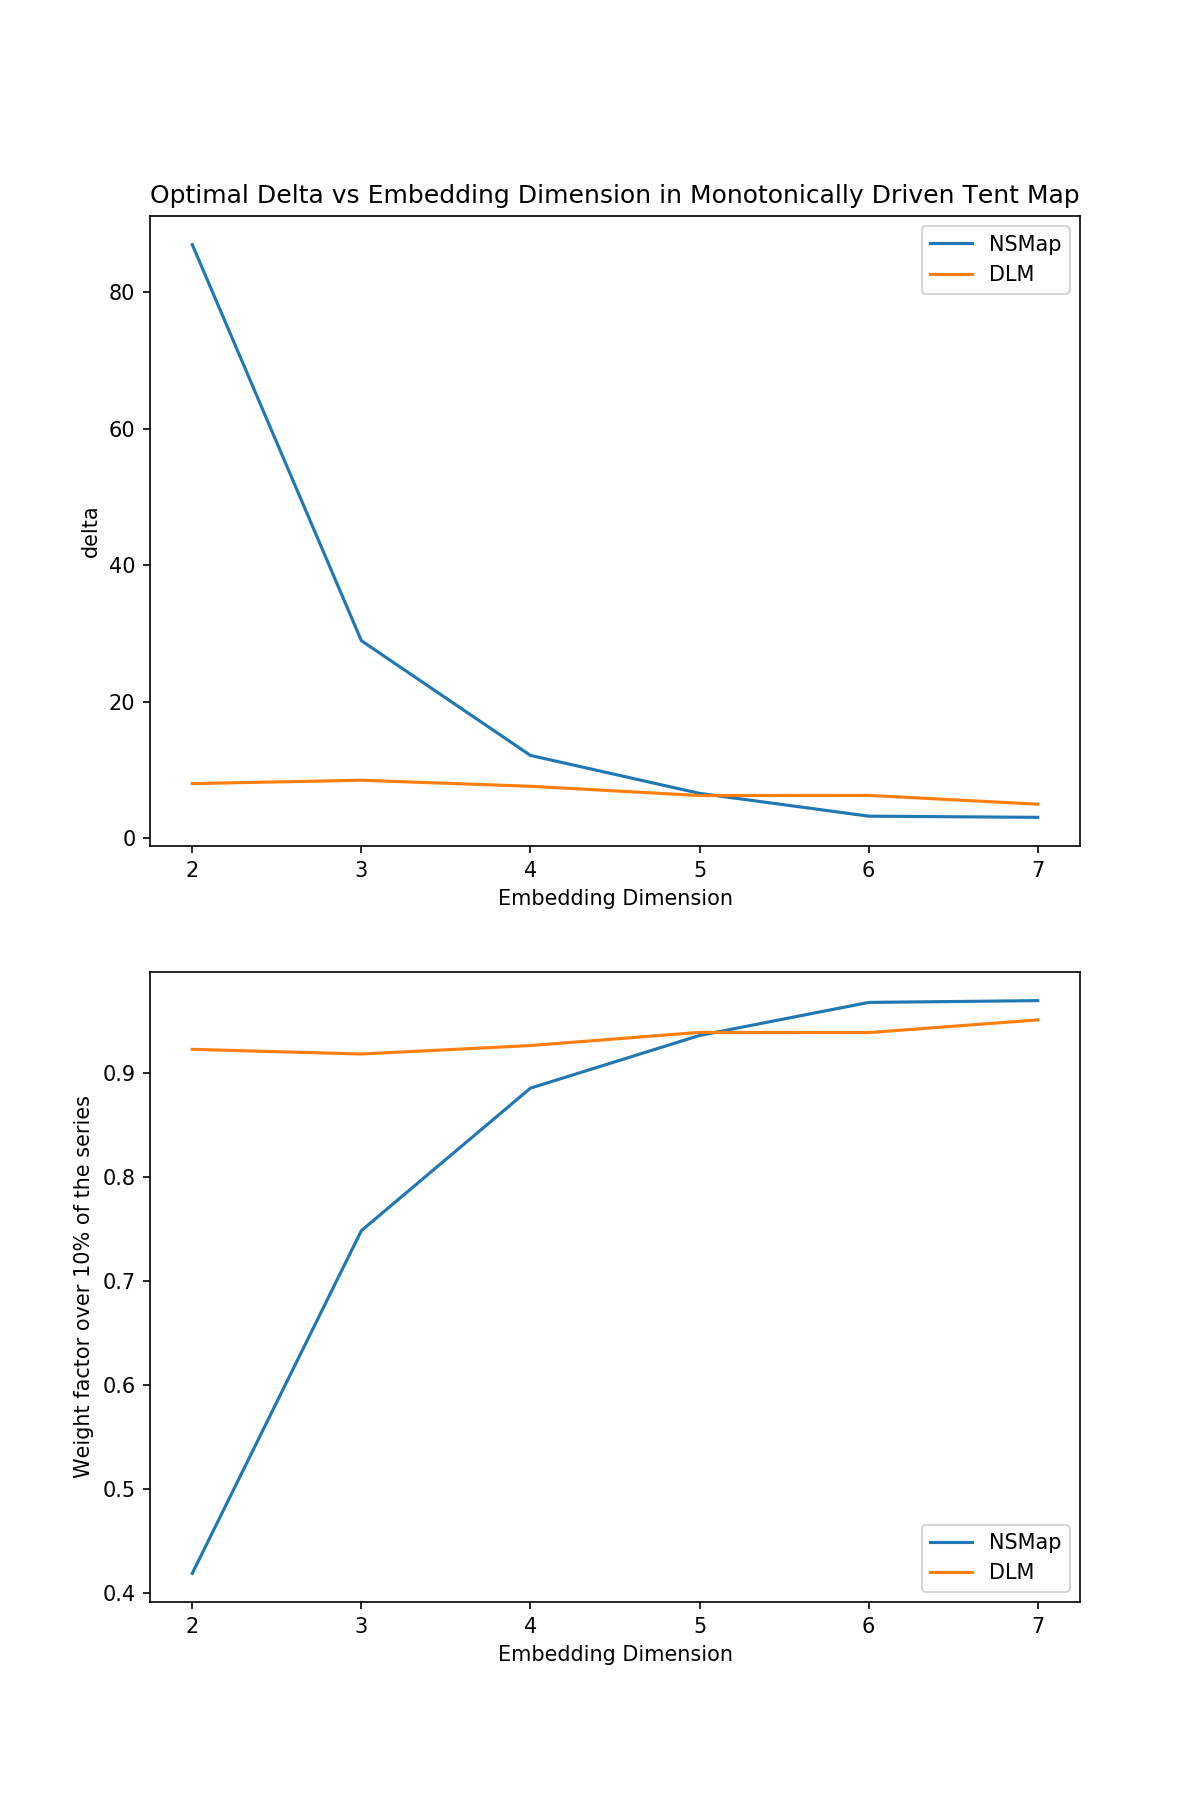

In [561]:
fix, ax = plt.subplots(2, figsize=(8,12))

ax[0].plot(np.arange(2,8), deltaNSandDLM[:,0], label="NSMap")
ax[0].plot(np.arange(2,8), deltaNSandDLM[:,1], label="DLM")
ax[0].set_xlabel("Embedding Dimension")
ax[0].set_ylabel("delta")
ax[0].legend()
ax[0].set_title("Optimal Delta vs Embedding Dimension in Monotonically Driven Tent Map")


ax[1].plot(np.arange(2,8), np.exp(-deltaNSandDLM[:,0]*(0.1**2)), label="NSMap")
ax[1].plot(np.arange(2,8), np.exp(-deltaNSandDLM[:,1]*(0.1**2)), label="DLM")
ax[1].set_xlabel("Embedding Dimension")
ax[1].set_ylabel("Weight factor over 10% of the series")
ax[1].legend()

plt.show()

<IPython.core.display.Javascript object>


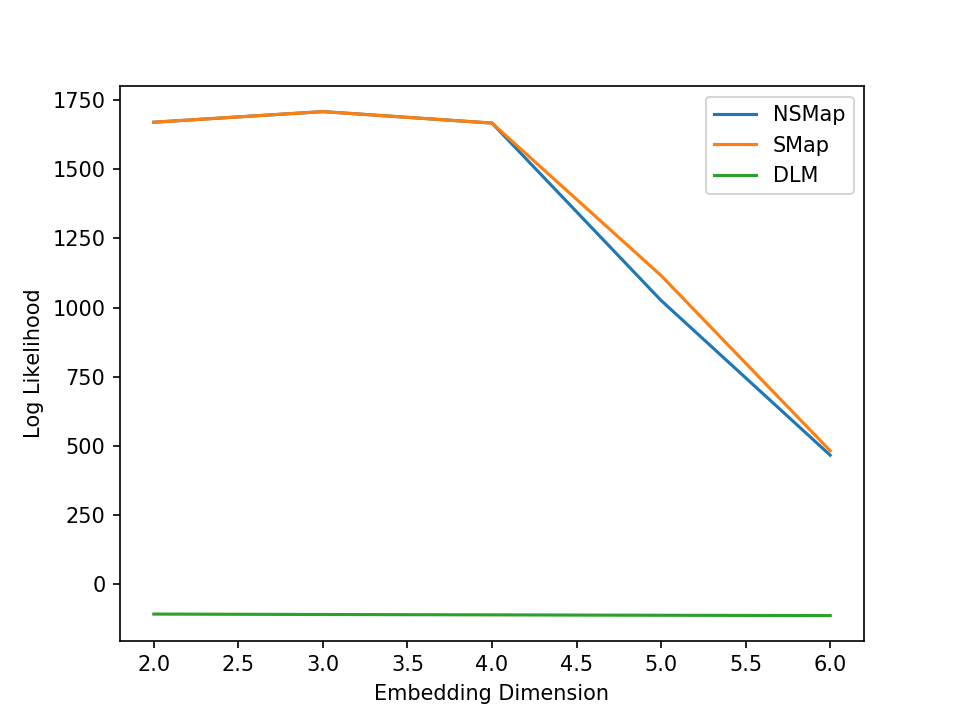

In [600]:
Es = np.array(range(2,maxLags+2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Es, evslikelihood[:,0], label="NSMap")
ax.plot(Es, evslikelihood[:,1], label="SMap")
ax.plot(Es, evslikelihood[:,2], label="DLM")
ax.set_xlabel("Embedding Dimension")
ax.set_ylabel("Log Likelihood")
ax.legend()
plt.show()

E=2
E=3
E=4
E=5
E=6
E=7


<IPython.core.display.Javascript object>


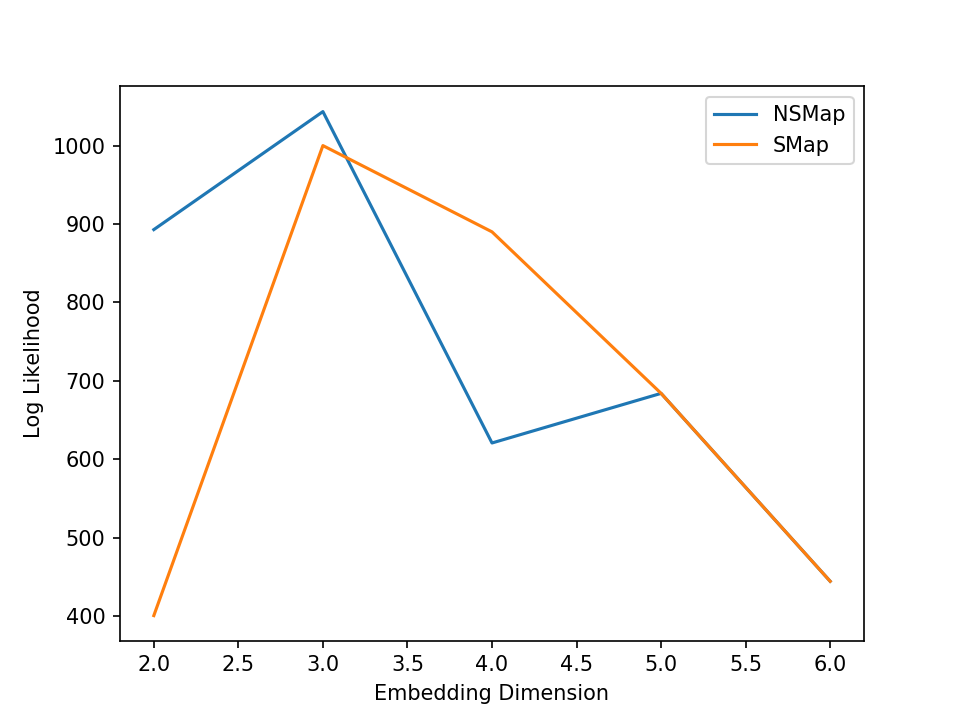

In [627]:
## AREA NONSTATIONARY MEASURE ##

stationary_probability = StationaryProbability(Xr, t, 1, 5)

<IPython.core.display.Javascript object>


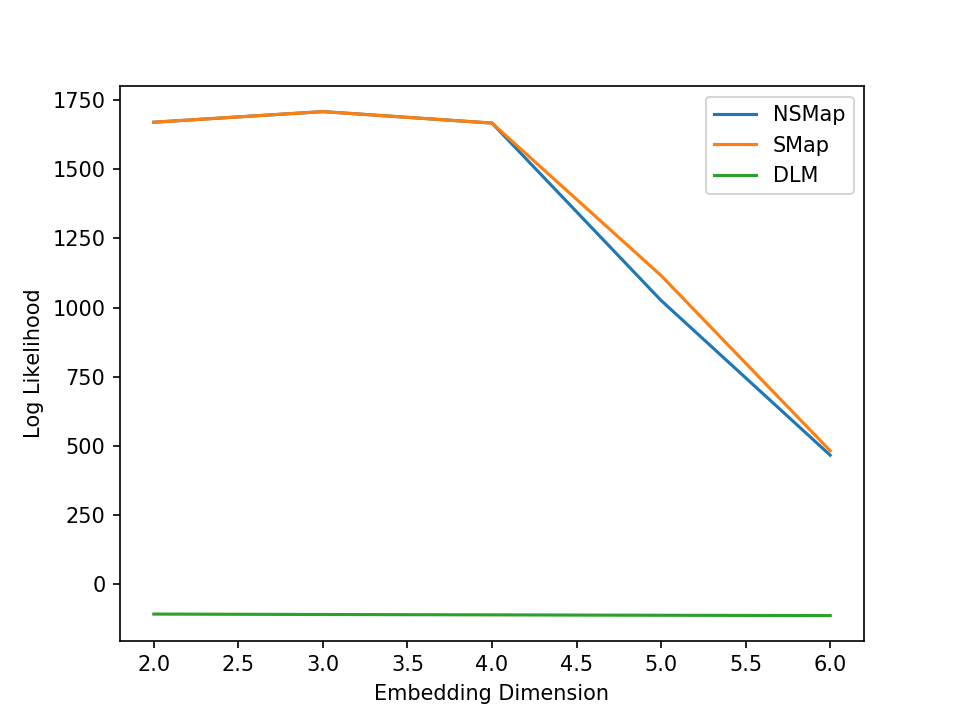

In [599]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(2,maxLags+2), evslikelihood[:,0], label="NSMap")
ax.plot(range(2,maxLags+2), evslikelihood[:,1], label="SMap")
ax.plot(range(2,maxLags+2), evslikelihood[:,2], label="DLM")
ax.set_xlabel("Embedding Dimension")
ax.set_ylabel("Log Likelihood")
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.plot(driverVdelta[:,0],driverVdelta[:,1])
ax.set_xlabel("Slope of driver")
ax.set_ylabel("Drop in weight over 10% of series length")
ax.text(1.55,0.98,f"r={np.corrcoef(driverVdelta[:,0],driverVdelta[:,1])[0,1]}")

In [520]:
hehe = np.zeros((100,2))
delbas = np.linspace(0,100, num=100)

for i, delba in enumerate(delbas):
    dlnL, lnL = gradient(Xs, Ys, txs, 5, delba)
    
    hehe[i] = np.array([lnL, dlnL[1]])

[410.16614343  77.27765225]
[488.55187792  73.38080668]
[552.3013163  52.2944205]
[596.18142311  36.08127134]
[627.70679056  27.24093137]
[652.46728133  22.19307702]
[673.1036113   18.85365131]
[690.82558626  16.33284192]
[706.2527601   14.27435229]
[719.76913771  12.53439081]
[731.65953702  11.04697344]
[742.15787767   9.77253034]
[751.46339172   8.68047393]
[759.74661161   7.74421004]
[767.15272953   6.94011669]
[773.80454749   6.24749063]
[779.80543328   5.64854364]
[785.24220235   5.12825305]
[790.18778076   4.67408811]
[794.70355628   4.27567618]
[798.84138519   3.92446223]
[802.64526605   3.61339367]
[806.15271505   3.33664587]
[809.39588629   3.08939176]
[812.40248078   2.86761305]
[815.19648359   2.66794773]
[817.79876273   2.48756789]
[820.22755748   2.32408202]
[822.49887824   2.17545691]
[824.62683583   2.03995519]
[826.62391387   1.91608493]
[828.50119551   1.80255904]
[830.26855309   1.69826223]
[831.93480762   1.60222407]
[833.50786347   1.51359678]
[834.99482287   1.4316

<IPython.core.display.Javascript object>


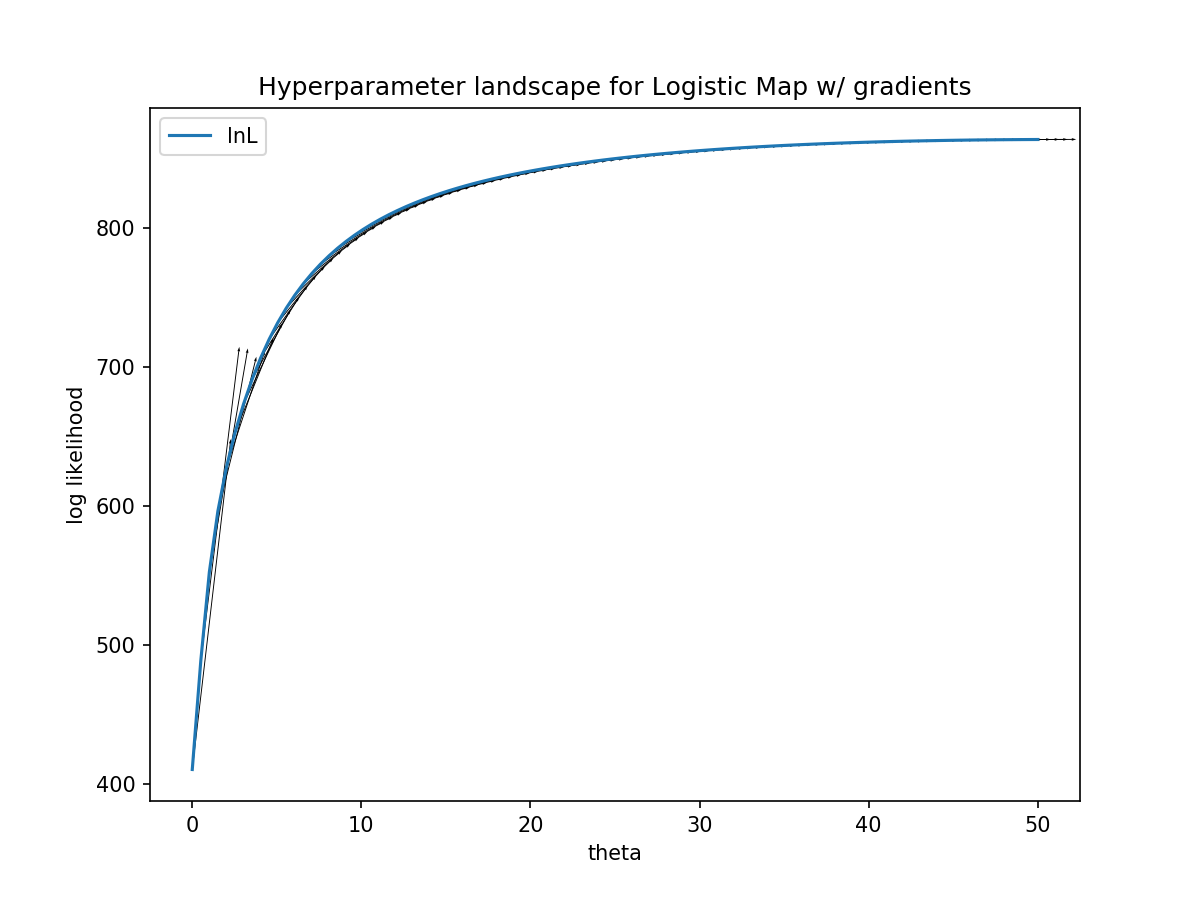

In [523]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.set_title("Hyperparameter landscape for Logistic Map w/ gradients")
ax.plot(thebas, hehe[:,0], label="lnL")
# ax.plot(thebas, hehe[:,1], label="lnL")
ax.set_ylabel("log likelihood")
ax.set_xlabel("theta")
ax.quiver(thebas,hehe[:,0], np.ones(100)*9, hehe[:,1], width=0.001)
ax.legend()

plt.show()

<IPython.core.display.Javascript object>


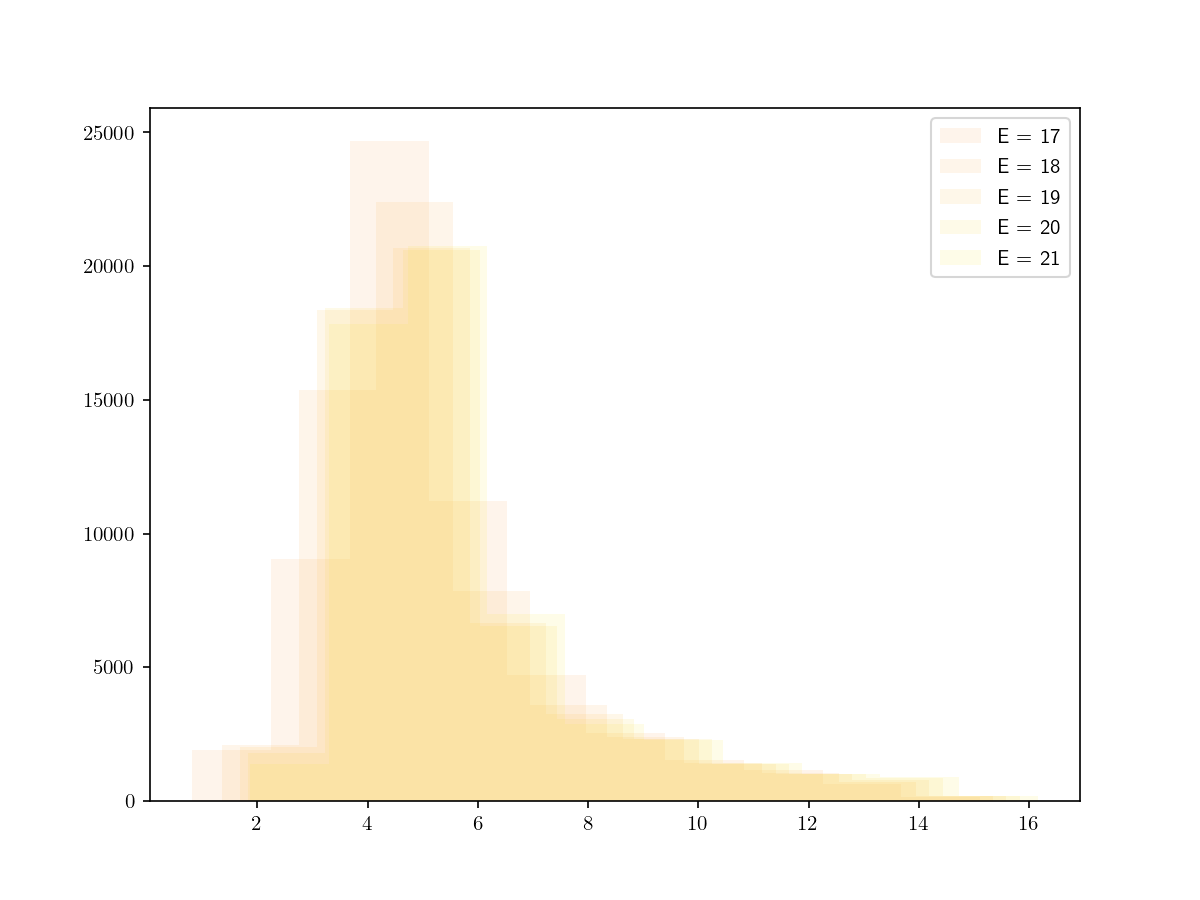

In [61]:
fig, ax = plt.subplots(1, figsize = (8,6))

for lags in range(15,20):
    X, Y = delayEmbed(Xr, 1, lags, 1)
    
    norms = np.zeros((len(X), len(X)))
    
    for i,x in enumerate(X):
        for j,y in enumerate(Y):
            norms[i,j] = la.norm(x-y)
    
    ax.hist(norms.flatten(), alpha=0.1, label=f"E = {lags+2}", color=cm.plasma(lags/20))

ax.legend()
plt.show()

In [57]:
Colormap()

NameError: name 'Colormap' is not defined